In [2]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
import datetime
import pyfolio as pf
import backtrader as bt
from collections import OrderedDict
from backtrader.feeds import PandasData
import warnings
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from talib import RSI, BBANDS, MACD

# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [1]:
!pip install yfinance
!pip install git+https://github.com/quantopian/pyfolio
!pip install backtrader 
!pip install ta-lib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [3]:
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Data Gathering

In [4]:
# ticker and the start and end dates for testing
ticker =  input("Enter ticker: ")
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2023, 1, 1)

Enter ticker: ^GSPC


In [5]:
# download ticker stock price from yahoo finance
stock =  yf.download(ticker,start=start, end=end,interval='1d')['Adj Close']
stock = pd.DataFrame(stock)
stock.rename(columns = {'Adj Close':'close'}, inplace=True)
stock.head(2)

[*********************100%***********************]  1 of 1 completed


,close
Date,
2013-01-02,1462.420044
2013-01-03,1459.369995


In [6]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(3)

,close,returns,direction
Date,,,
2013-01-03,1459.369995,-0.002088,-1
2013-01-04,1466.469971,0.004853,1
2013-01-07,1461.890015,-0.003128,-1


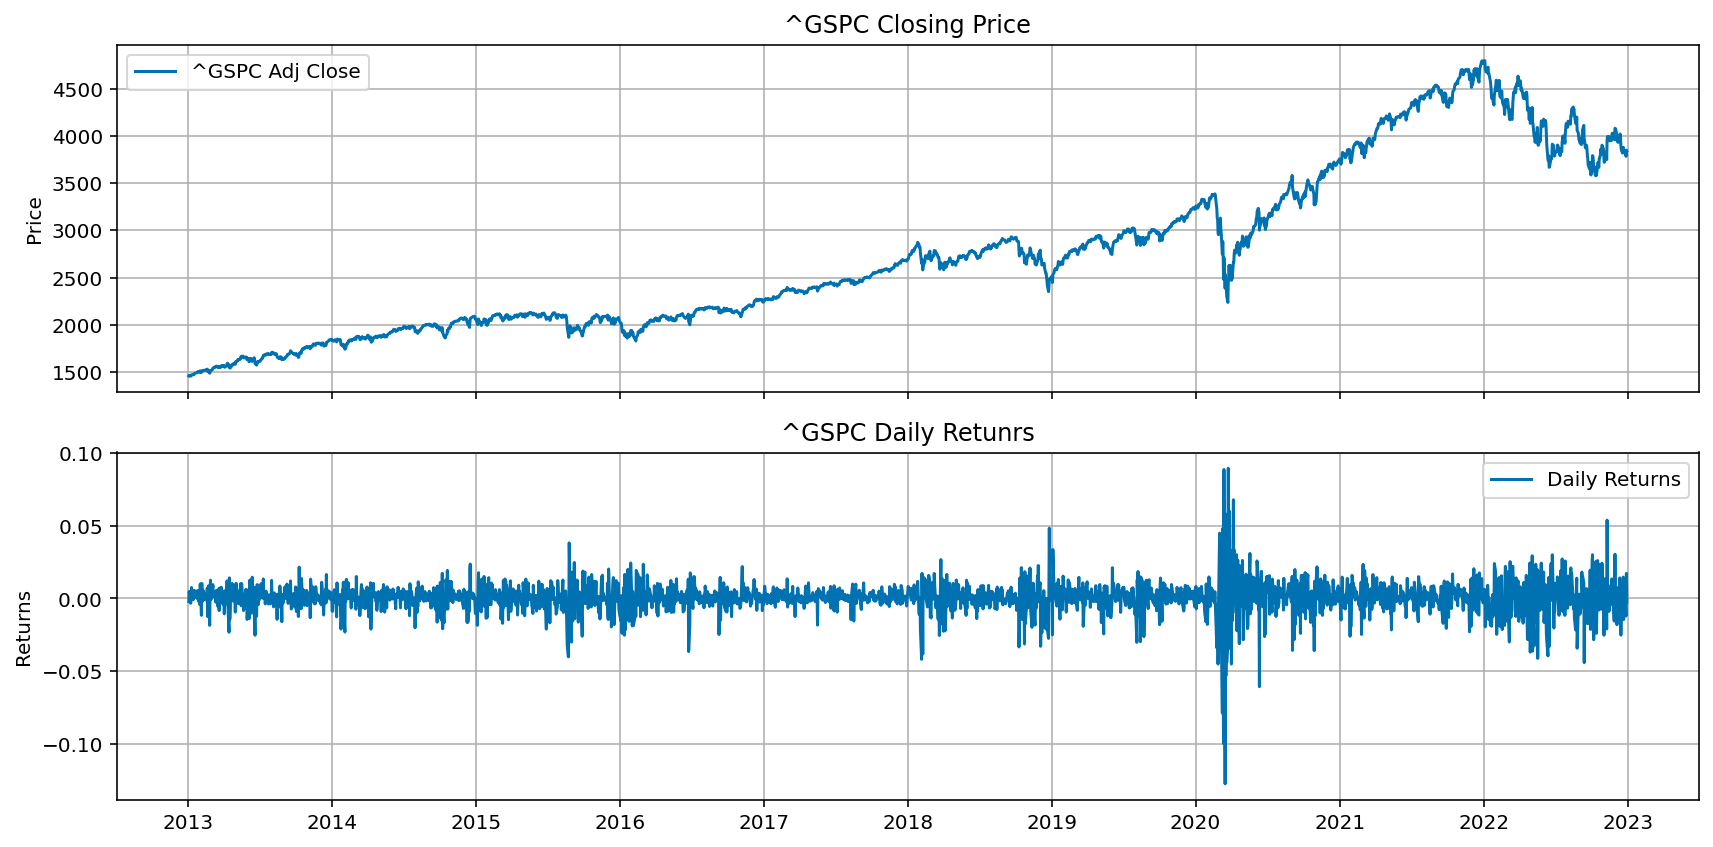

In [7]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock.close, label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()

plt.tight_layout();

Feature Engineering

In [8]:
# define the number of lags
lags = [1, 2, 3, 4, 5] 

In [9]:
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)
stock.head(2)

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5
Date,,,,,,,,
2013-01-03,1459.369995,-0.002088,-1,NaN,NaN,NaN,NaN,NaN
2013-01-04,1466.469971,0.004853,1,-0.002088,NaN,NaN,NaN,NaN


In [10]:
# RSI - Relative Strenght Index
stock['rsi'] = RSI(stock.close)

# append to feature columns list
cols.append('rsi')
stock.tail(2)

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi
Date,,,,,,,,,
2022-12-29,3849.280029,0.017311,1,-0.012093,-0.004058,0.005851,-0.014557,0.014759,45.996490
2022-12-30,3839.500000,-0.002544,-1,0.017311,-0.012093,-0.004058,0.005851,-0.014557,45.177869


In [11]:
# Compute Bollinger Bands
high, mid, low = BBANDS(stock.close, timeperiod=20)
stock = stock.join(pd.DataFrame({'bb_high': high, 'bb_low': low}, index=stock.index))

# append to feature columns list
cols.append('bb_high')
cols.append('bb_low')

In [12]:
# Compute Moving Average Convergence/ Divergence
stock['macd'] = MACD(stock.close)[0]

# append to feature columns list
cols.append('macd')

build and apply this model 

In [13]:
# split the dataset in training and test datasets
train, test = train_test_split(stock.dropna(), test_size=0.4, shuffle=False)

# sort the data on date index
train = train.copy().sort_index()
test = test.copy().sort_index() 

In [14]:
# define a function to create the deep neural network model
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=len(cols)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', #'rmsprop', 
                  metrics=['accuracy'])
    return model

In [15]:
# normalized the training dataset
mu, std = train.mean(), train.std()
train_ = (train - mu) / mu.std()

In [16]:
# create the model
model = create_model()

In [17]:
# map market direction of (1,-1) to (1,0)
train['direction_'] = np.where(train['direction'] > 0, 1, 0)

In [18]:
%%time
# fit the model for training dataset
r = model.fit(train_[cols], train['direction_'], epochs=50, verbose=False) 

CPU times: user 5.26 s, sys: 350 ms, total: 5.61 s
Wall time: 6.07 s


In [19]:
# normalized the test dataset
mu, std = test.mean(), test.std()
test_ = (test - mu) / std

In [20]:
# map market direction of (1,-1) to (1,0)
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

In [21]:
# evaluate the model with test dataset
model.evaluate(test_[cols], test['direction_'])

32/32 [==============================] - 0s 2ms/step - loss: 16.3965 - accuracy: 0.6429


[16.396514892578125, 0.6428571343421936]

In [22]:
# predict the direction and map it (1,0)
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

32/32 [==============================] - 0s 1ms/step


array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0])

In [23]:
# based on prediction calculate the position for strategy
test['position_strategy'] = np.where(pred > 0, 1, -1)

In [24]:
# calculate daily returns for the strategy
test['strategy_return'] = test['position_strategy'] * test['returns']

In [25]:
# calculate total return and std. deviation of each strategy
print('\nTotal Returns:')
print(test[['returns', 'strategy_return']].sum().apply(np.exp))
print('\nAnnual Volatility:')
print(test[['returns', 'strategy_return']].std() * 252 ** 0.5)


Total Returns:
returns             1.458278
strategy_return    24.290332
dtype: float64

Annual Volatility:
returns            0.230363
strategy_return    0.224734
dtype: float64


In [26]:
# number of trades over time for the strategy
print('Number of trades = ', (test['position_strategy'].diff()!=0).sum())

Number of trades =  393


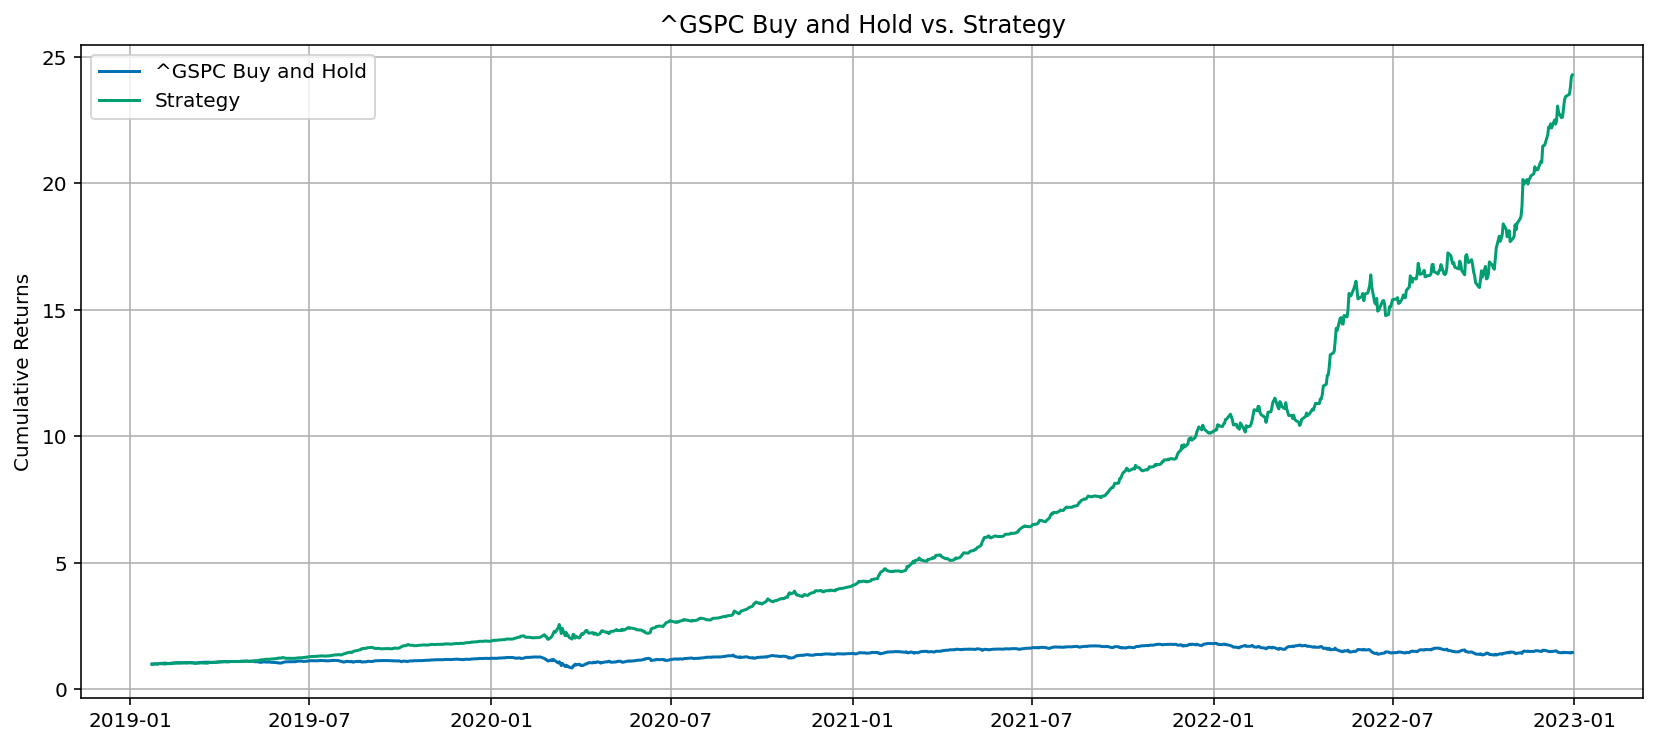

In [27]:
# plot cumulative returns
fig, ax = plt.subplots(1, 1, sharex=True, figsize = (14,6))
ax.plot(test.returns.cumsum().apply(np.exp), label = ticker + ' Buy and Hold')
ax.plot(test.strategy_return.cumsum().apply(np.exp), label = 'Strategy')
ax.set(title = ticker + ' Buy and Hold vs. Strategy', ylabel = 'Cumulative Returns')
ax.grid(True)
ax.legend()
plt.show()

Backtesing Using backtrader

In [28]:
# backtesting start and end dates
start = test.index[0]
end = test.index[-1]
print(start)
print(end)

2019-01-23 00:00:00
2022-12-30 00:00:00


In [29]:
# fetch the daily pricing data from yahoo finance
prices =  yf.download(ticker, progress=True, actions=True, start=start, end=end)
prices.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2019-01-23,2643.479980,2653.189941,2612.860107,2638.699951,2638.699951,3358770000,0.0,0.0
2019-01-24,2638.840088,2647.199951,2627.010010,2642.330078,2642.330078,3449230000,0.0,0.0


In [30]:
# rename the columns as needed for Backtrader
prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
                         }, inplace=True)

In [31]:
prices.head(3)

,open,high,low,close,volume
Date,,,,,
2019-01-23,2643.479980,2653.189941,2612.860107,2638.699951,3358770000
2019-01-24,2638.840088,2647.199951,2627.010010,2642.330078,3449230000
2019-01-25,2657.439941,2672.379883,2657.330078,2664.760010,3821000000


In [32]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = test.strategy_return
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'strategy_return':'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.head(2)

,predicted,open,high,low,close,volume
Date,,,,,,
2019-01-23,-0.002200,2643.479980,2653.189941,2612.860107,2638.699951,3358770000
2019-01-24,-0.001375,2638.840088,2647.199951,2627.010010,2642.330078,3449230000


In [33]:
prices[['predicted']].sum().apply(np.exp)

predicted    24.228617
dtype: float64

In [34]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [35]:
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

####Strategy:

Buy when the predicted value is +1 and sell (only if stock is in possession) when the predicted value is -1. All-in strategy—when creating a buy order, buy as many shares as possible. Short selling is not allowed

In [36]:
 ###define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
            
         # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
#                 self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
#                 self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)


In [37]:
# instantiate SignalData class
data = SignalData(dataname=prices)

In [38]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro( cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100_000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [39]:
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2019-01-25, BUY EXECUTED --- Price: 2657.44, Cost: 98325.28,Commission: 98.33
2019-01-29, SELL EXECUTED --- Price: 2644.89, Cost: 98325.28,Commission: 97.86
2019-01-29, OPERATION RESULT --- Gross: -464.35, Net: -660.54
2019-01-30, BUY EXECUTED --- Price: 2653.62, Cost: 98183.94,Commission: 98.18
2019-01-31, SELL EXECUTED --- Price: 2685.49, Cost: 98183.94,Commission: 99.36
2019-01-31, OPERATION RESULT --- Gross: 1179.19, Net: 981.64
2019-02-06, BUY EXECUTED --- Price: 2735.05, Cost: 98461.80,Commission: 98.46
2019-02-13, SELL EXECUTED --- Price: 2750.30, Cost: 98461.80,Commission: 99.01
2019-02-13, OPERATION RESULT --- Gross: 549.00, Net: 351.53
2019-02-14, BUY EXECUTED --- Price: 2743.50, Cost: 98766.00,Commission: 98.77
2019-02-19, SELL EXECUTED --- Price: 2769.28, Cost: 98766.00,Commission: 99.69
2019-02-19, OPERATION RESULT --- Gross: 928.08, Net: 729.62
2019-02-21, BUY EXECUTED --- Price: 2780.24, Cost: 100088.64,Commission: 100.09
2019-02-26, S

In [40]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)

index
2019-01-23 00:00:00+00:00    0.0
2019-01-24 00:00:00+00:00    0.0
Name: Strategy, dtype: float64

In [41]:
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = ticker
benchmark_rets

Date
2019-01-23 00:00:00+00:00    0.002200
2019-01-24 00:00:00+00:00    0.001375
2019-01-25 00:00:00+00:00    0.008453
2019-01-28 00:00:00+00:00   -0.007878
2019-01-29 00:00:00+00:00   -0.001457
                               ...   
2022-12-22 00:00:00+00:00   -0.014557
2022-12-23 00:00:00+00:00    0.005851
2022-12-27 00:00:00+00:00   -0.004058
2022-12-28 00:00:00+00:00   -0.012093
2022-12-29 00:00:00+00:00    0.017311
Name: ^GSPC, Length: 993, dtype: float64

In [42]:
# get performance statistics for strategy
pf.show_perf_stats(returns)

Start date,2019-01-23
End date,2022-12-29
Total months,47
,Backtest
Annual return,-3.463%
Cumulative returns,-12.967%
Annual volatility,16.715%
Sharpe ratio,-0.13
Calmar ratio,-0.14
Stability,0.38
Max drawdown,-25.363%


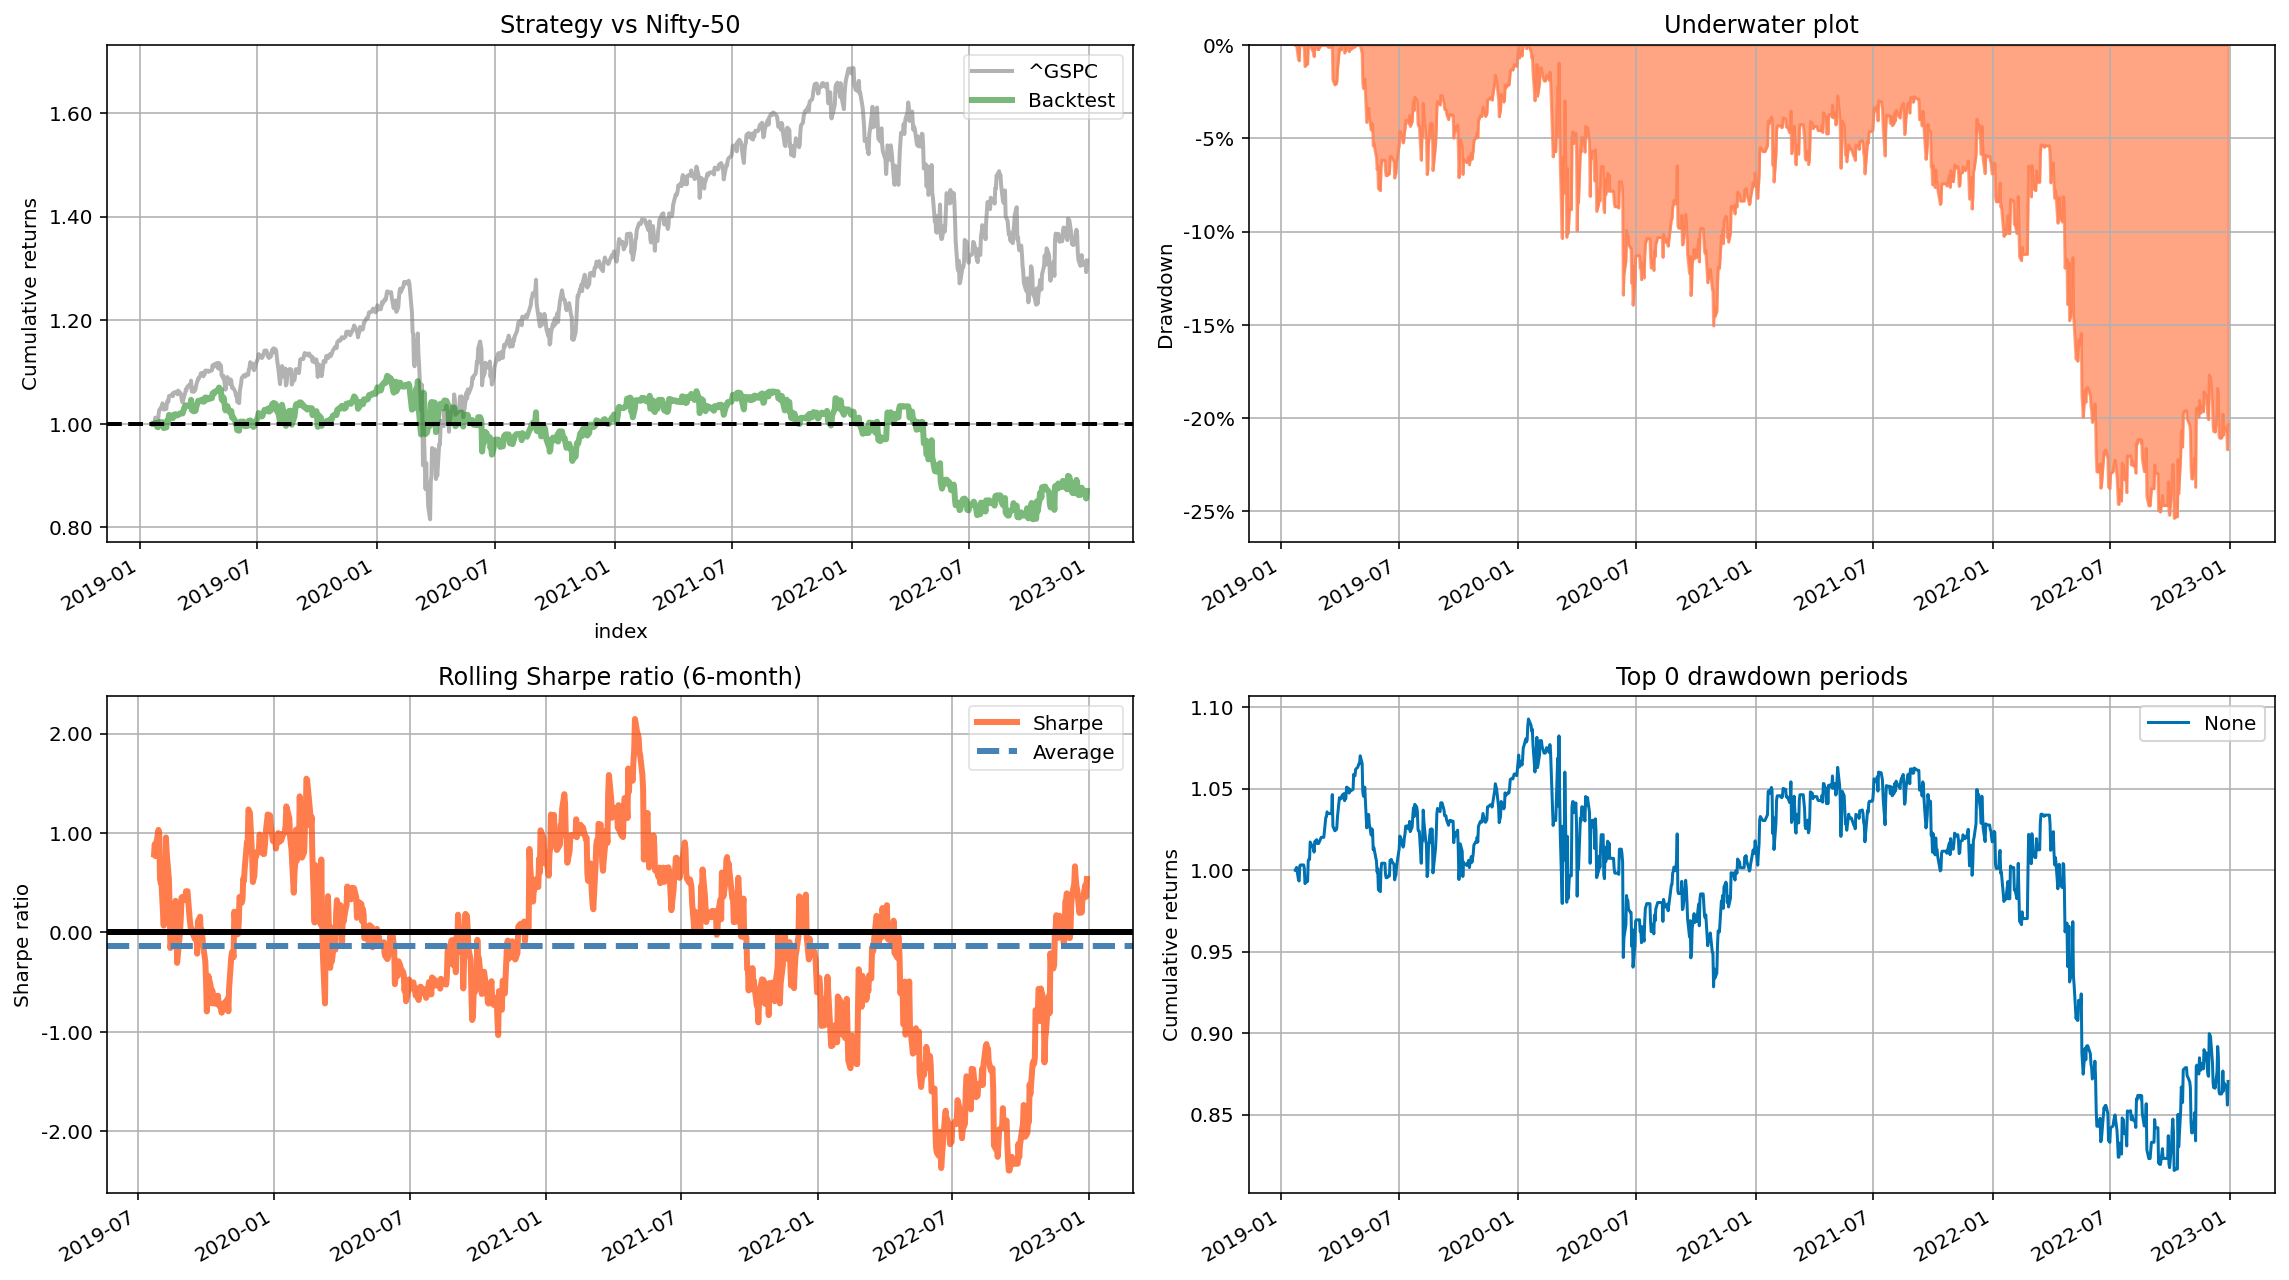

In [43]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

# pf.plot_drawdown_periods(returns=returns,top=0)
# axes[0].grid(True)


pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[0], title='Strategy vs Nifty-50')
axes[0].grid(True)

pf.plot_drawdown_underwater(returns=returns, ax=axes[1])
axes[1].grid(True)

pf.plot_rolling_sharpe(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_drawdown_periods(returns=returns,
                         top = 0)

plt.grid(True)
plt.legend()
plt.tight_layout()

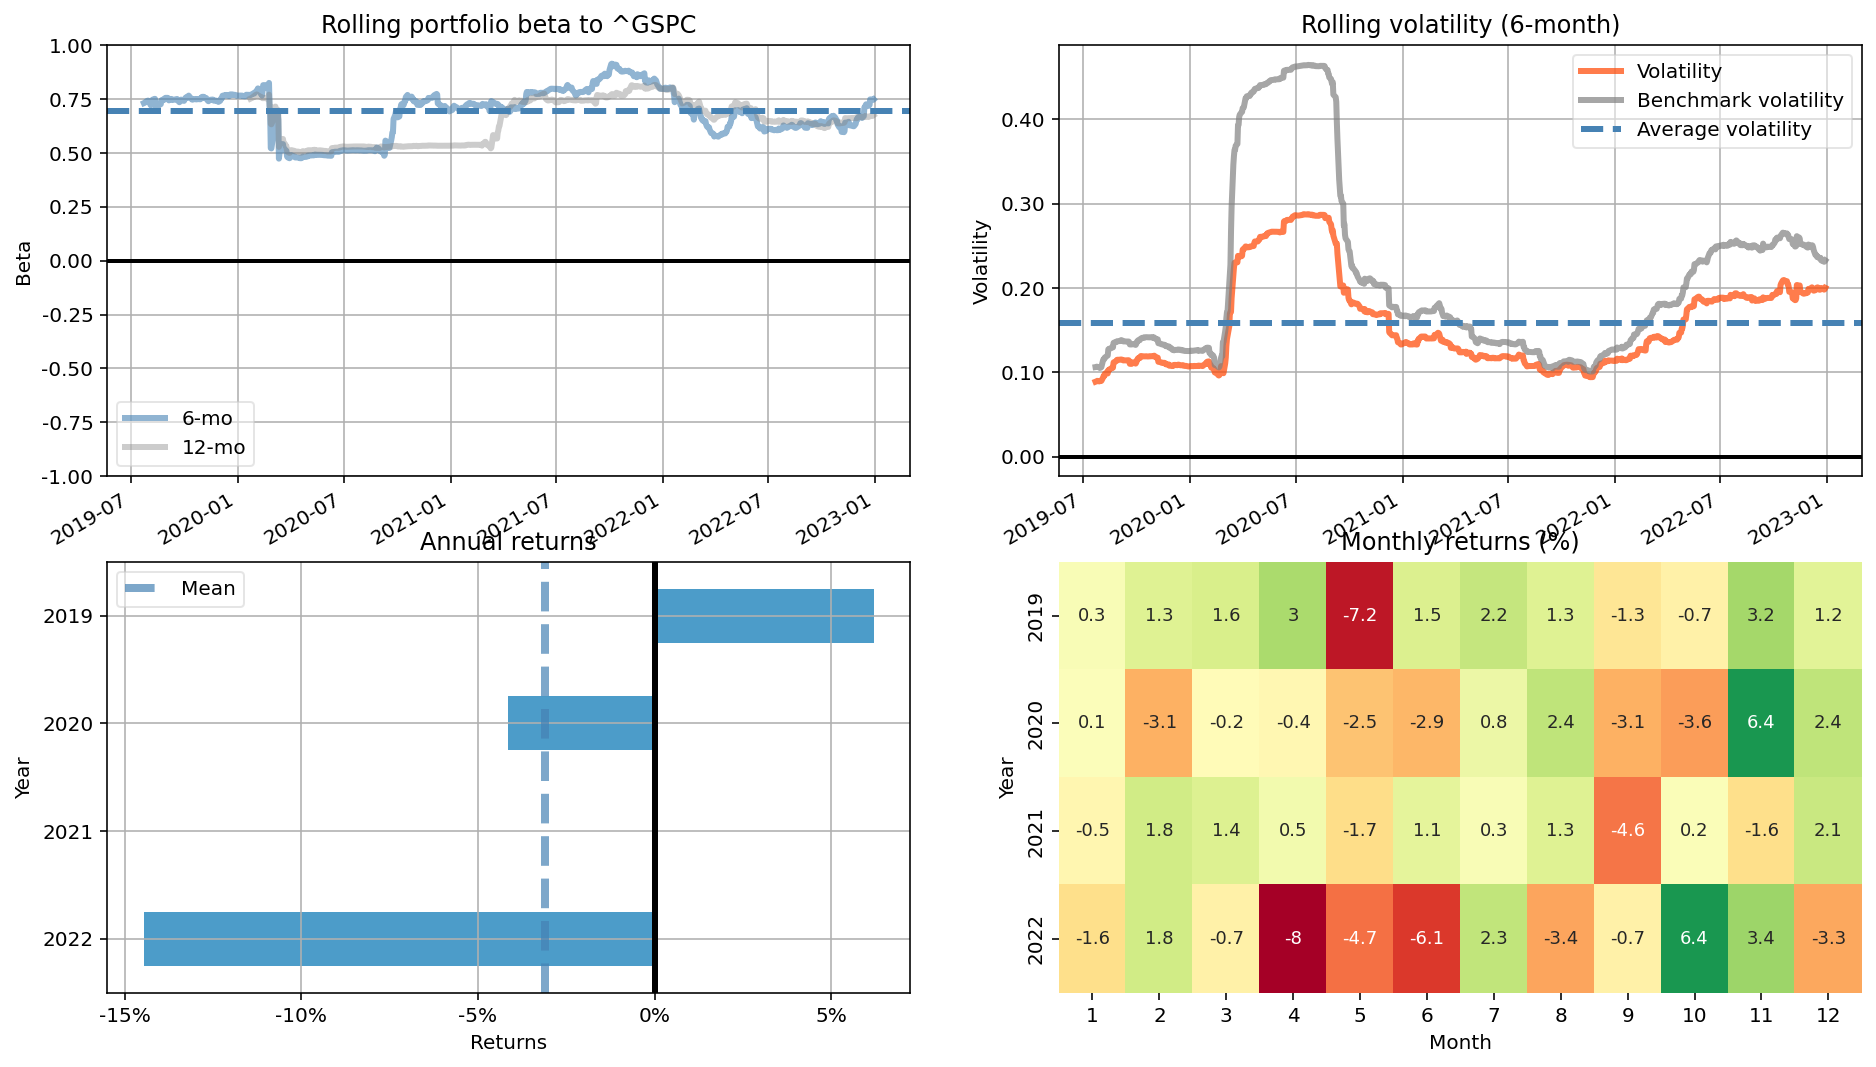

In [44]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
axes[0].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
axes[1].grid(True)

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)
# fig.suptitle('XXX', fontsize=16, y=1.0)


plt.tight_layout()
plt.savefig(fname='data',dpi=300)